# LSTM Neural Network Fitting Analysis

## Preamble

The aim of this analysis is to develop a pipeline that consists of a LSTM Neural Network (LSTM NN) that given the opening stock price of a stock over the previous 40 days, can accurately predict the current opening stock price.  This project was inspired by the work done by Yacoub Ahmed that can be found here https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe.  The aim is while using his original LSTM NN as a starting point, is to improve it and then leverage it to create a simulation of some stock trading on a few automobile stocks.  In the interest of academic honesty, it must be noted that while we took our inspiration from Yacoub and used his original LSTM model, all code used here is original.

Note, in call cases where we train a LSTM NN, we have commented it out and replaced it with code that loads in the models from memory.  This is done to save the markers time from having to retrain the models.  Which I certainly do not recommend unless you have a GPU at your disposal.

In [1]:
# Reading in neccessary packages
from datetime import date, timedelta
import numpy as np
import pandas as pd
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.utils import resample

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
data = pd.read_csv('Data/ford.csv', index_col='Date')

## Check for Reasonable Predictor

To begin, we will build our model on Ford stock from January 1st, 2000 to November 17, 2020 (The day I am creating this).  Lets first as a formality check that the daily opening stock price is actually correlated to the previous days opening stock price.  To check this, we will create a plot of the sample correlation (ACF) below.  If we examine the AF plot below, we can clearly see that the opening price is highly correlated to the previous days opening stock price.  We can actually see this continues for many lags k.  Of course the reader may be wondering what we mean by lag k?  Let the opening stock price of ford be represented by the time series process ${Y_t}$.  The current days opening stock price we are interested in can be denated as $Y_t$.  Then in the plot below we can a high correlation between $Y_t$ and $Y_{t-k}$ where k is some integer k that denotes some number of units back in time.  For instance, from the plot below we can see that the sample ACF between $Y_t$ and $Y_{t-2}$ produces a sample ACF very close to 1.  Moving on, our conclusion from this plot is simply that the current opening stock price of Ford has a high correlation with its past opening stock prices.  Thus, it could be a strong predictor.  Lastly, the question remains how far back in the past to predict the current opening stock price.  That is many many past days should we use to predict the current day.  To choose this we arbitrarilty chose 4.

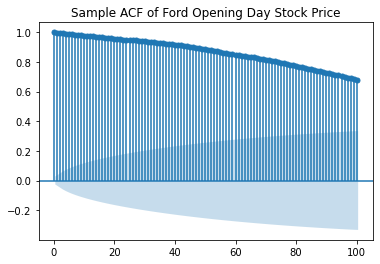

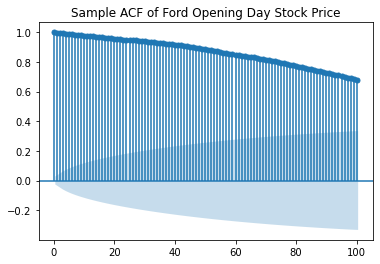

In [3]:
# CITATION: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711
plot_acf(data['Open'], lags=100, title='Sample ACF of Ford Opening Day Stock Price')

# NOTE: for some reason this produces 2 of the same plot, it could not be removed.

## Set Up Code

The following few cells contain code that will be use to create, and evaluate the models

In [4]:
# This defines the numpy of days in the past we will use to predict the current price
LAG = 40

In [5]:
# Plots the results of a mode.
def plot(yHat, y, title):
    plt.plot(y)
    plt.plot(yHat)
    plt.legend(['Real', 'Predicted'])
    plt.title(title)
    plt.show()
    

In [6]:
# Calculates the MSE
def mse(x, y):
    preds = model.predict(x)
    preds = scaler.inverse_transform(preds)
    unscaled_yTest = scaler.inverse_transform(np.reshape(y, (-1, 1)))
    return np.mean(np.square(preds-unscaled_yTest)), preds, unscaled_yTest

In [7]:
# This function accepts the raw data and transforms it into the form required for the LSTM NN.  
# - It removes unneccessary columns
# - scales the data between 0 and 1
# - transforms into numpy arrays
def transform(df, n=40):
    df = pd.DataFrame(df['Open'])  # Removing all the other columns as we are only predicting if we should buy based on the opening stock price

    
    # Normalizing to 0-1 range
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df)
    df = pd.DataFrame(scaler.transform(df), columns=df.columns, index=pd.to_datetime(df.index))


    # Creating 40 columns that give the past 40 day opening stock price
    for i in range(1, n + 1):
        df[f'Open-{i}'] = df['Open'].shift(i)

    # Subsetting for the neccessary columns
    df = df.iloc[40:, 0:]

    # Splitting into training and testing data (test size is about last 2 years)
    dt = pd.to_datetime(date(2020, 11, 17) - timedelta(days=730))
    train = df[df.index < dt]
    test = df[df.index >= dt]     

    # Splitting into appropriat x and y values
    xTrain = train.iloc[:, 1:]
    yTrain = train.iloc[:, 0]
    xTest = test.iloc[:, 1:]
    yTest = test.iloc[:, 0]

    # Converting to numpy arrays to feed into model
    xTrain = xTrain.to_numpy()
    yTrain = yTrain.to_numpy()
    xTest = xTest.to_numpy()
    yTest = yTest.to_numpy()

    # Reshaping to get correct form
    xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))
    xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))

    return xTrain, yTrain, xTest, yTest, scaler

In [8]:
def saveModel(model, name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"{location}/{name}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{location}/{name}.h5")
    print("Saved model to disk")

def loadModel(name, location='Data'):
    # CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    # load json and create model
    json_file = open(f"{location}/{name}.json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(f"{location}/{name}.h5")
    return model
    print("Loaded model from disk")



In [9]:
xTrain, yTrain, xTest, yTest, scaler = transform(data, LAG)

In [10]:
# Setting the batch size for the model.
BATCH_SIZE = int(xTrain.shape[0]/3)
# BATCH_SIZE = xTrain.shape[0]

In [11]:
def modelTraining(epoch, batchSize, neuronsLSTM1=50,neuronsLSTM2=128, neuronsDense=64, learningRate=0.0005):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        # model.add(LSTM(neuronsLSTM1,input_shape=(xTrain.shape[1],xTrain.shape[2]), return_sequences=True))
        model.add(Dropout(0.2))
        # model.add(LSTM(neuronsLSTM2))
        # model.add(Dropout(0.2))
        model.add(Dense(neuronsDense))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))
        opt = tf.keras.optimizers.Adam(lr=learningRate)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, batch_size=batchSize, epochs=epoch, shuffle=True)
    return model

## Model Tuning 1: Batch Size

Using our model as defined above, we explore the affect of batch sizes using of 10, 32(Default), 100, 500, 1000, 1500, and 2000.  All with a standard of 1000 epochs.

In [23]:
# batches = pd.DataFrame(columns=['batchSize', 'mseTrain','mseTest'])
# for batchSize in [10,32 ,100, 500, 1000, 1500, 2000, 2500, 3000]:
#     model = modelTraining(1000, batchSize)
#     mseTrain, yHat, y = mse(xTrain,yTrain)
#     mseTest, yHat, y = mse(xTest,yTest)
#     batches = batches.append({'batchSize':batchSize, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)

#     saveModel(model, f"fordBatchTraining{batchSize}", location='Data')

# batches.to_csv('Data/fordBatchTraining.csv')

results = pd.read_csv('Data/fordBatchTraining.csv')
results
    


,batchSize,mseTrain,mseTest
0,10,0.053750,0.007168
1,32,0.069077,0.006059
2,100,0.096221,0.005149
3,500,0.135626,0.013121
4,1000,0.181391,0.006829
5,1500,0.246180,0.010500
6,2000,0.363314,0.035387
7,2500,0.421914,0.046237
8,3000,0.215748,0.005812


Looking at the above results of changing the batch size, we see mixed results with the potential that our predictions get worse as we increase the batch size.  We can see this as the MSof the training data does appear to increase as our batch size increases.  To verify the results, lets plot the results of the models with a batch size 10, 2000 and 3000 respectively.

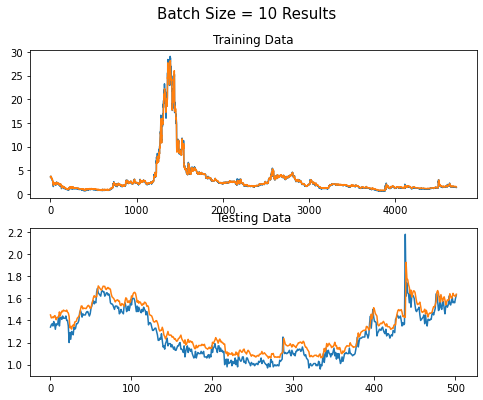

In [22]:
model = loadModel(name='fordBatchTraining10')


# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 10 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")

meanSquared, yHat, y = mse(xTest,yTest)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")

plt.show()

0.36331427200357713
0.035387185616672805


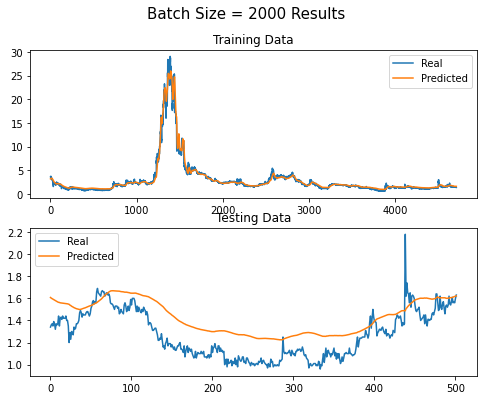

In [21]:
model = loadModel(name='fordBatchTraining2000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 2000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

0.21574778866367464
0.00581204641572969


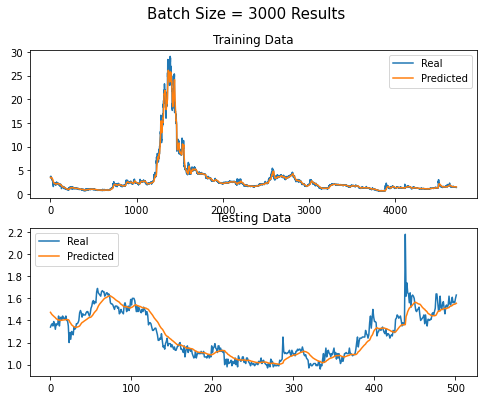

In [20]:
model = loadModel(name='fordBatchTraining3000')
# CITATION: https://riptutorial.com/matplotlib/example/11257/grid-of-subplots-using-subplot
meanSquared, yHat, y = mse(xTrain,yTrain)
print(meanSquared)
fig, axes = plt.subplots(2, figsize=(8, 6))

# Set the title for the figure
fig.suptitle('Batch Size = 3000 Results', fontsize=15)

# Top Left Subplot
axes[0].plot(y)
axes[0].plot(yHat)
axes[0].set_title("Training Data")
axes[0].legend(['Real', 'Predicted'])

meanSquared, yHat, y = mse(xTest,yTest)
print(meanSquared)
# Top Right Subplot
axes[1].plot(y)
axes[1].plot(yHat)
axes[1].set_title("Testing Data")
axes[1].legend(['Real', 'Predicted'])

We can clearly see that as the batch sizes increases, the fit of the model on the testing data worsens significantly.  This is particularly interesting for the batch size = 3000 where the testing MSE is actually quite good, but the training MSE is poor.  Ultimatly, we conclude that a smaller batch size is best.

## Model Tuning 2: Epochs

To achieve a better fit, we will now try to tune the number of epochs the model must iterate through to train the model.  To do so we will try epochs of 50, 100, 500, 1000, 2000, and 3000.

In [ ]:
batches = pd.DataFrame(columns=['epcohs', 'mseTrain','mseTest'])
for e in [10,32 ,100, 500, 1000, 1500, 2000, 2500, 3000]:
    model = modelTraining(1000, 10)
    mseTrain, yHat, y = mse(xTrain,yTrain)
    mseTest, yHat, y = mse(xTest,yTest)
    batches = batches.append({'batchSize':batchSize, 'mseTrain': mseTrain, 'mseTest':mseTest}, ignore_index=True)

    saveModel(model, f"fordBatchTraining{batchSize}", location='Data')

batches.to_csv('Data/fordBatchTraining.csv')

results = pd.read_csv('Data/fordBatchTraining.csv')
results
    

## First Model
We have now transformed the data into the required format with both a training and testing.  So lets try fitting to a model!

In [16]:
# CITATION 1: https://www.youtube.com/watch?v=BSpXCRTOLJA
# CITATION 2: https://towardsdatascience.com/getting-rich-quick-with-machine-learning-and-stock-market-predictions-696802da94fe
# Citation 1 was used as a starting point to get the model to make at least semi-accurate predictions.
with tf.device("gpu:0"):
    model = Sequential()
    model.add(LSTM(128,input_shape=(xTrain.shape[1],xTrain.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(64))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('linear'))


    opt = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(optimizer=opt, loss='mse')
    model.fit(xTrain,yTrain, epochs=3000, batch_size=BATCH_SIZE)

    # serialize model to JSON
    model_json = model.to_json()
    with open("data/fordLSTM_50Epochs.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("data/fordLSTM_50Epochs.h5")
    print("Saved model to disk")

# CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# load json and create model
# json_file = open('data/fordLSTM_50Epochs.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("data/fordLSTM_50Epochs.h5")
# print("Loaded model from disk")



011
Epoch 2761/3000
4/4 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2762/3000
4/4 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2763/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2764/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2765/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2766/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2767/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2768/3000
4/4 [==============================] - 0s 12ms/step - loss: 0.0011
Epoch 2769/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0010
Epoch 2770/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0011
Epoch 2771/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0013
Epoch 2772/3000
4/4 [==============================] - 0s 11ms/step - loss: 0.0016


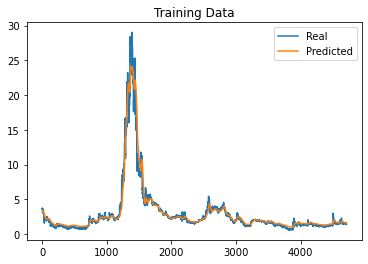

MSE: 0.5880039523969687


In [17]:
meanSquared, yHat, y = mse(xTrain,yTrain)
plot(yHat, y, 'Training Data')
print("MSE:",meanSquared)

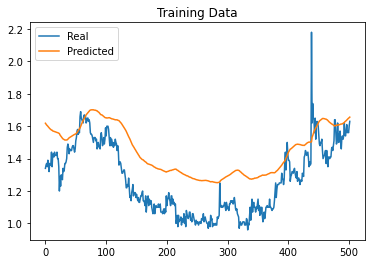

MSE: 0.042358694167463434


In [18]:
meanSquared, yHat, y = mse(xTest,yTest)
plot(yHat, y, 'Training Data')
print("MSE:",meanSquared)

We can see the results of our model above.  We can see our model begin to take the rough shape of the actual shape of the Test Data.  However, we need it to be far closer.  As we will see shortly, the model is in fact very undertrained.  To adjust for this, lets run the model on varying Epochs (i.e. how many times you run the data through to train the model).  We will test this on 50,100,500,1000, 2000, 2500 and 3000 epochs and record the MSE to give a rough evaluation of the models.  Note, the different epochs were chosen as a combination of both arbitrarilty and through trial and error.

## Model Tuning 1: Epochs

In [67]:
# def epochs(epoch):
#     with tf.device("gpu:0"):
#         model = Sequential()
#         model.add(LSTM(128,input_shape=(xTrain.shape[1],xTrain.shape[2])))
#         model.add(Dropout(0.2))
#         model.add(Dense(64))
#         model.add(Activation('sigmoid'))
#         model.add(Dense(1))
#         model.add(Activation('linear'))

#         opt = tf.keras.optimizers.Adam(lr=0.0005)
#         model.compile(optimizer=opt, loss='mse')
#         # model.fit(train_dataset, epochs=i,validation_data = test_dataset, use_multiprocessing=True, workers=8, batch_size=BATCH_SIZE)
#         model.fit(xTrain,yTrain, epochs=epoch, batch_size=BATCH_SIZE)
#         return model

# res = pd.DataFrame(columns=['epoch','mseTest','mseTrain'])
# for i in [50,100,500,1000,2000,2500,3000]:
#     model = epochs(i)
#     meanSquaredTest, yHat, y = mse(xTest,yTest)
#     meanSquaredTrain, yHat, y = mse(xTrain,yTrain)
#     res = res.append({'epoch':i,'mseTest':meanSquaredTest,'mseTrain':meanSquaredTrain},ignore_index=True)

#     # serialize model to JSON
#     model_json = model.to_json()
#     with open(f"data/fordLSTM_{i}Epochs.json", "w") as json_file:
#         json_file.write(model_json)
#     # serialize weights to HDF5
#     model.save_weights(f"data/fordLSTM_{i}Epochs.h5")
#     print("Saved model to disk")

# res.to_csv("epochResults.csv")
res = pd.read_csv("epochResults.csv")
res



,Unnamed: 0,epoch,mseTest,mseTrain
0,0,50.0,0.024447,5.165668
1,1,100.0,0.375613,2.023062
2,2,500.0,0.513497,3.257916
3,3,1000.0,0.172833,1.063658
4,4,2000.0,0.043386,0.876366
5,5,2500.0,0.015286,0.529018
6,6,3000.0,0.128612,1.625686


Above we see the results of training the model further.  We can clearly see that MSE decreases as we continue to train the model.  However, when we reach 3000 epochs the MSE of the Testing data begins to increase and the MSE of the Training Data begins to decrease.  Is is possible that we are overfitting the data at 3000 epochs.  Thus, we will use 2000 epochs in our model.  Below we vizualize the result of the 2500 epoch model.

In [36]:
# CITATION: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
json_file = open('data/fordLSTM_2500Epochs.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("data/fordLSTM_2500Epochs.h5")
print("Loaded model from disk") 


Loaded model from disk


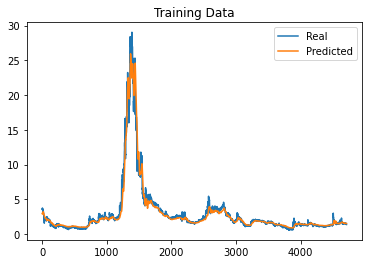

MSE: 0.5290175907305708


In [42]:
plot(yHat, y, 'Training Data')
meanSquared, yHat, y = mse(xTrain,yTrain)
print("MSE:",meanSquared)

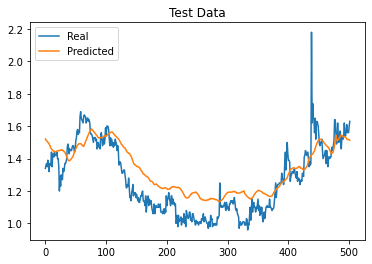

MSE: 0.01528621021655068


In [58]:
plot(yHat, y, 'Test Data')
meanSquared, yHat, y = mse(xTest,yTest)
print("MSE:",meanSquared)

Above are the plots of our test and training data.  The results appear to be significantly improved considering we have not done any formal tuning at this point.  Surprisingly, we can actually see that that model appears to perform better on the testing data than the training data.  We take this as an indication that the model does not appear to be over fitting the training data.  Thus, no further dropouts will be added to the model nor will any adjustments be made there.  However, we will continue to try and improve the model. 

Note, the reader may notice that the MSE of the 2000 epoch model displayed with their respective plots differs from the MSE of the 2000 epoch model displayed in the tabel above.  This is likely due to where the MSE's were computed.  While the code was the same, the MSE in the table above was computed on Google Colab while training the models and the MSE computed with the plots was done locally.  There is perhaps some difference of rounding.

In [ ]:
## Model Tuning 2: Learning Rate

Seeing as we will stick with an epoch of 2500.  Lets attempt to optimize the learning rate for this number of epochs.  We will use a log scale of 0.1,0.001,0.0001,0. 

## Model Tuning 2: Neurons
Lets now tune the number of hidden nodes contained in the LSTM layer.  Note, the original value of 128 was chosen arbitrarilty.  To test this, we will do so on a model with 500 epochs to minimize computation time.  Furthermore, not that the range of neurons chosen is in fact arbitraty.

In [ ]:
def epochs(neurons):
    with tf.device("gpu:0"):
        model = Sequential()
        model.add(LSTM(neurons,input_shape=(xTrain.shape[1],xTrain.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(64))
        model.add(Activation('sigmoid'))
        model.add(Dense(1))
        model.add(Activation('linear'))

        opt = tf.keras.optimizers.Adam(lr=0.0005)
        model.compile(optimizer=opt, loss='mse')
        model.fit(xTrain,yTrain, epochs=500, validation_data=(xTest,yTest))
        return model

res = pd.DataFrame(columns=['neurons','mseTest','mseTrain'])
for i in [50,70,90,100,120,140]:
    model = epochs(i)
    meanSquaredTest, yHat, y = mse(xTest,yTest)
    meanSquaredTrain, yHat, y = mse(xTrain,yTrain)
    res = res.append({'neurons':i,'mseTest':meanSquaredTest,'mseTrain':meanSquaredTrain},ignore_index=True)

      # serialize model to JSON
    model_json = model.to_json()
    with open(f"data/fordLSTM_{i}Neurons.json", "w") as json_file:
    json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"data/fordLSTM_{i}Neurons.h5")
    print("Saved model to disk")

res.to_csv("neuronResults.csv")


# res = pd.read_csv("epochResults.csv")
# res

In [42]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11836189200443633486
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6910041152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7473195948957447547
physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6"
]
